#**Password Cracking**

##**Flowchart**

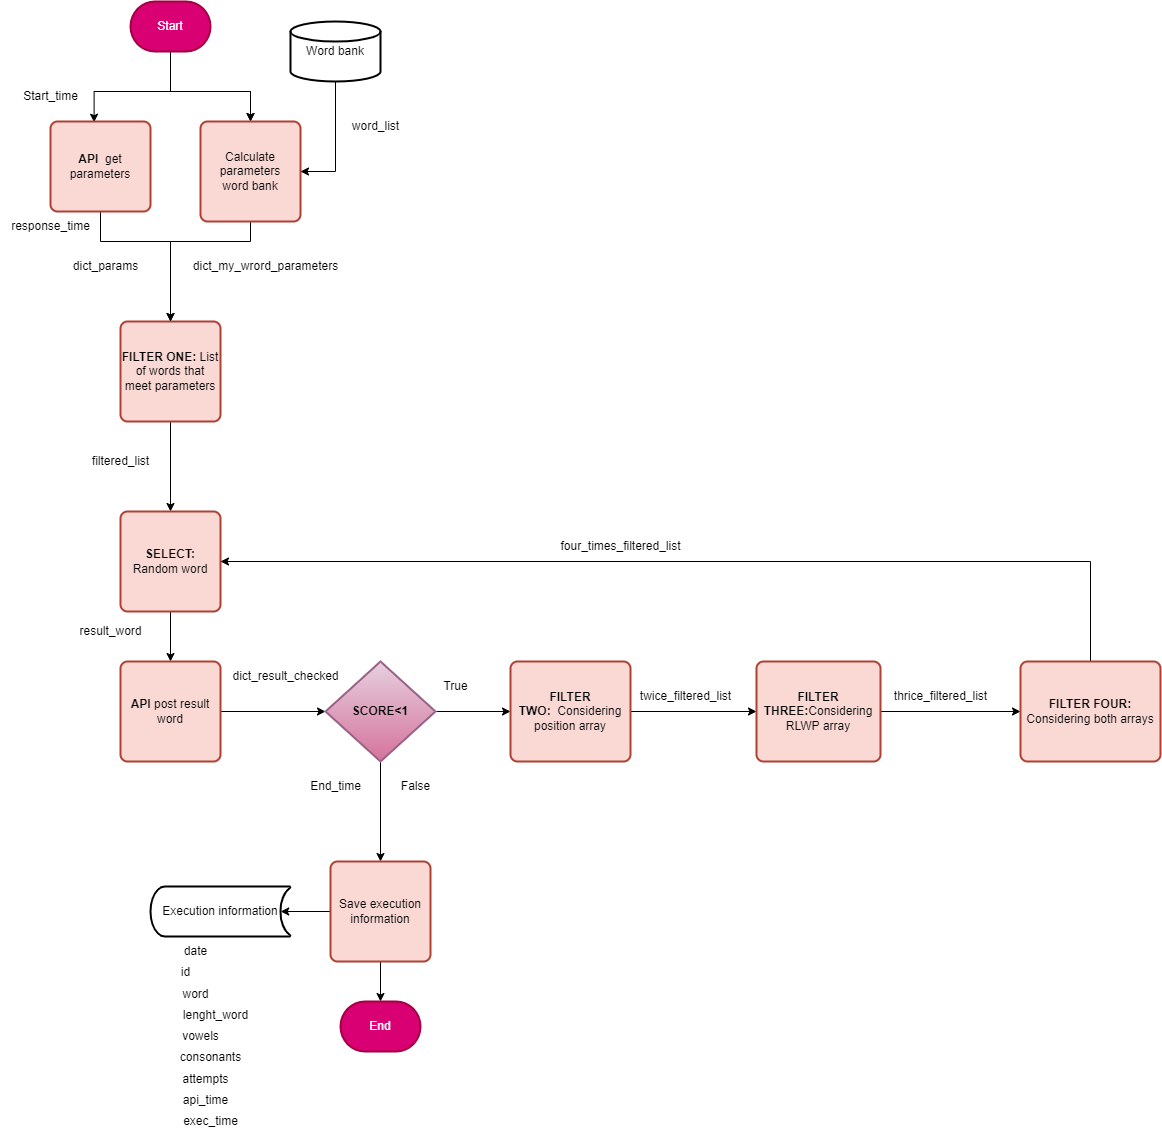

##**Preparation**

In [1]:
# Import libraries
import os
import requests
import random
import time
import csv

In [2]:
# Get word list from word bank
work_path ='/content/drive/Othercomputers/My Laptop/SoftkaU/Reto/Work'
os.chdir(work_path)
with open('word_bank_daniela.txt','r', encoding='utf8') as word_bank:
  word_bank = word_bank.read()
  word_list = word_bank.split()

In [3]:
# API | endpoints
endpoint_get= ' https://7b8uflffq0.execute-api.us-east-1.amazonaws.com/game/get_params'
endpoint_post= 'https://7b8uflffq0.execute-api.us-east-1.amazonaws.com/game/check_results'

In [4]:
# Vowels List
vowels_list = ['a', 'e', 'i','o','u']

##**Functions**

###API

In [5]:
# Define function
# API | get initial parameters
def get_parameters():
  response_get_params = requests.get(endpoint_get, auth = ('daniela.puerta','7fd5749d72254b52830722846df4076a'))
  dict_params = response_get_params.json() # Converts the json file to a dictionary
  return dict_params

In [6]:
# Define function
# API | post result word
def post_result_word(result_word):
  # Sent result word
  result_word_json = {
  'result_word': result_word
  }
  response_post_result_word = requests.post(endpoint_post, json = result_word_json, auth = ('daniela.puerta','7fd5749d72254b52830722846df4076a'))
  dict_result_checked = response_post_result_word.json() # Converts json to a dict
  return dict_result_checked

###Parameters

In [7]:
# Define function
# Calculate word lenght
def word_lenght(word):
  my_word_lenght = len(word)
  return my_word_lenght

In [8]:
# Define function
# Calculate word number of vowels
def word_vowels(word):
  my_word_vowels = sum([word.count(vowel) for vowel in vowels_list])
  return my_word_vowels

In [9]:
# Define function
# Calculate word parameters
def word_parameters(word):
  my_word_parameters = []
  my_word_parameters.append(word_lenght(word))
  my_word_parameters.append(word_vowels(word))
  return my_word_parameters

In [10]:
# Define function
# Create a dictionary with every word parameters
def parameters_dict(word_list):
  dict_my_word_parameters = dict.fromkeys(word_list,[])
  for word in word_list:
    my_word_parameters = word_parameters(word)
    dict_my_word_parameters[word] = my_word_parameters # Structure => {'word' : [lenght,vowels]}
  return dict_my_word_parameters

In [11]:
# Define function
# True letter in a word
def true(word, position_array):
  trues_index = [i for i, x in enumerate(position_array) if x]
  trues = [word[i] for i in trues_index]
  return trues

###Filters

In [12]:
# Define function
# Filter one: Create a list with words from word bank that meet given parameters
def filter_one(word_list, dict, length_word, vowels):
  filtered_list = [word for word in word_list if (dict[word][0] == length_word and dict[word][1] == vowels )]
  return filtered_list

In [13]:
# Define function
# Filter two: Compare words with the word sent considering the position array
def filter_two(word_list, word_sent, position_array):
  remove_words = []
  for word in word_list:
    for pos, char in enumerate(word):
      if word[pos] != word_sent[pos] and position_array[pos] == True:
        remove_words.append(word)
        break
      elif word[pos] == word_sent[pos] and position_array[pos] == False:
        remove_words.append(word)
        break
  twice_filtered_list = list(set(word_list).difference(set(remove_words)))
  return twice_filtered_list

In [14]:
# Define function
# Filter three: Delete words that do not have all of the letters in the RLWP array
def filter_three(word_list, right_letters_in_wrong_position):
  remove_words = []
  for word in word_list:
    check = all(char in word for char in right_letters_in_wrong_position)
    if check == False:
      remove_words.append(word)
  thrice_filtered_list = list(set(word_list).difference(set(remove_words)))
  return thrice_filtered_list

In [15]:
# Define function
# Filter four: Delete words that have letters that are not in the word (word_sent - RLWP - trues)
def filter_four(word_list, word_sent, position_array, right_letters_in_wrong_position):
  remove_words = []
  # word_sent - RLWP
  diff = list(set(word_sent).difference(set(right_letters_in_wrong_position)))
  # (word_sent - RLWP)- trues
  trues = true(word_sent, position_array)
  wrong_letters = list(set(diff).difference(set(trues)))
  for word in word_list:
    if any(char in word for char in wrong_letters):
      remove_words.append(word)
  four_times_filtered_list = list(set(word_list).difference(set(remove_words)))
  return four_times_filtered_list 

###Others

In [16]:
# Define function
# Select a word 
def select_word(word_list):
  result_word = random.choice(word_list)
  return result_word  

###Game

In [29]:
# Defining function
# Play
def play():
  # API | Request parameters
  start_time = time.time()
  dict_params = get_parameters()
  response_time =time.time()
  # Calculate API performance time
  time_api = (response_time - start_time)
  print('Tiempo de respuesta de la API:',time_api,'segundos')
  # Filter One
  filtered_list = filter_one(word_list, dict_my_word_parameters, dict_params['length_word'], dict_params['vowels'])
  # Select first word
  result_word = select_word(filtered_list)
  # API | Post result word
  dict_result_checked = post_result_word(result_word)
  # Guess Cycle
  while dict_result_checked['score'] < 1:
    # Filter two 
    twice_filtered_list = filter_two(filtered_list,result_word,dict_result_checked['position_array'])
    # Filter three
    thrice_filtered_list = filter_three(twice_filtered_list, dict_result_checked['right_letters_in_wrong_positions'])
    # Filter four
    filtered_list = filter_four(thrice_filtered_list, result_word, dict_result_checked['position_array'], dict_result_checked['right_letters_in_wrong_positions'])
    # Select word
    result_word = select_word(filtered_list)
    # API | Post result word
    dict_result_checked = post_result_word(result_word) 
  # Calculate game time
  end_time = time.time()
  exec_time = (end_time - response_time)
  print('Tiempo de ejecución:', exec_time,'segundos')
  print('Contraseña descifrada:',dict_result_checked['word_sent'])
  print('Tomó', dict_result_checked['current_attemps'],'intentos')
  # Save data
  dict_info_game = {
      'date':dict_result_checked['try_datetime']
      ,'id':dict_params['id'],'word':result_word
      ,'lenght_word':dict_params['length_word']
      ,'vowels':dict_params['vowels']
      ,'consonants':dict_params['consonants']
      ,'attempts':dict_result_checked['current_attemps']
      ,'api_time':time_api
      ,'exec_time':exec_time
      }

##**Crack the password**

In [18]:
# Calculate parameters for every word in word bank
dict_my_word_parameters = parameters_dict(word_list) # Structure -> {'word' : [lenght,vowels]}

In [30]:
# Crack the password
play()

Tiempo de respuesta de la API: 0.7517130374908447 segundos
Tiempo de ejecución: 0.8699591159820557 segundos
Contraseña descifrada: cristologicas
Tomó 2 intentos
